In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from sklearn import preprocessing

In [2]:
NBINS = 60
NE = 100000  # number of events per parametric
NP = 10000   # number of different parametrics

In [3]:
def inverse_sample_decorator(dist):
    def wrapper(pnts, x_min=-100, x_max=100, nbins=NBINS, n=1e5, **kwargs):
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        r_x = x * (13**0.5)
        #print(x.min(),x.max())
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        cumulative = scaler.fit_transform(cumulative.reshape(-1, 1))
        cumulative = cumulative.reshape(int(n))
        #plt.scatter(r_x, cumulative, label="CDF")
        cdf = interp1d(r_x, cumulative)
        bins = np.linspace(1,7,nbins+1)
        #print(bins)
        cdf_bins = cdf(bins)[1:] - cdf(bins)[:-1]
        #plt.scatter(cumulative, r_x, label="iCDF")
        #plt.legend()
        #plt.show()
        real_low = (cumulative).min()
        real_high = (cumulative).max()
        #print((cumulative/cumulative.max()).max(),(cumulative/cumulative.max()).min())
        ff = interp1d(cumulative, x)
        return ff(np.random.uniform(low=real_low, high=real_high, size=pnts)), cdf_bins 
    return wrapper

In [4]:
# First trying sampling from a simple gaussian distribution
@inverse_sample_decorator
def gauss(x, amp=1.0, mean=0.0, std=0.2):
    return amp*np.exp(-(x-mean)**2/std**2/2.0)

In [5]:
# Experimenting with Eq2
@inverse_sample_decorator
def f(x,ts=[1.1,1.2,1.3,1.4],nbins=60):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

In [6]:
def data_gen(pmin, pmax, na, nb, f, nbins=60, scaled=False, signal=False):
    init = True
    for i in range(nb):
        samples, y = f(na,ts=np.random.uniform(low=pmin,high=pmax,size=4), nbins=60,
                                            x_min=1/(13**0.5),x_max=7/(13**0.5))
        samples *= (13**0.5)
        
        if signal:
            print(samples.shape)
            sig_samples, _ = gauss(na//100, mean=3.5, std=0.5)
            print(sig_samples.shape)
            samples = np.concatenate((samples, sig_samples))
            print(samples.shape)
        
        plt.style.use("dark_background")
        
        
        n, bins = np.histogram(samples, bins=nbins)
            
        if scaled:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
            n = scaler.fit_transform(n.reshape(-1, 1))
            n = n.reshape(nbins)
            
        if init:
            X = np.array(n)
            Y = np.array(y)
            binsc = 0.5*(bins[1:] + bins[:-1]) 
            init = False

        else:
            X = np.vstack((X,n))
            Y = np.vstack((Y,y))
            
    plt.show()
    return X,Y,binsc

In [7]:
GEN = False
import h5py
if GEN:
    X,Y,binsc= data_gen(1.2,1.8,100000,10000,f,scaled=True)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    Y = Y.reshape(Y.shape[0], Y.shape[1], 1)

    hf = h5py.File("./data/bg-parametric.h5","w")
    hf.create_dataset("sample", data=X)
    hf.create_dataset("bin prob", data=Y)
    hf.close()
else:
    hf = h5py.File("./data/bg-parametric.h5","r")
    X = np.array(hf.get("sample"))
    Y = np.array(hf.get("bin prob"))
    
    bins = np.linspace(1,7,NBINS+1)
    binsc = 0.5*(bins[1:] + bins[:-1]) 
    
print(X.shape, Y.shape)

(10000, 60, 1) (10000, 60, 1)


In [8]:
def prob2event(x, binsx=[None]):
    n = x.size
    x = np.array(x)
    x.reshape(n)
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    x = (x * NE) 
    x = scaler.fit_transform(x.reshape(-1,1))
    x = x.reshape(n)
    if binsx[0] != None:
        scaler = preprocessing.MinMaxScaler(feature_range=(1,7))
        binsc = scaler.fit_transform(binsx.reshape(-1,1))
        return x, binsc
    return x

In [9]:
def plot1(X, Y, binsc=binsc, legend=True):
    plt.style.use("dark_background")
    plt.grid()
    plt.yscale("log")
    plt.ylim((10**-4,10**0))
    plt.xlabel("m[TeV]")
    plt.ylabel("Events per bin")
    plt.scatter(binsc,X, s=6, label="sample", c="cyan")
    plt.scatter(binsc,prob2event(Y), s=6, label="bin prob", c="orange")
    if legend:
        plt.legend()
    plt.show()

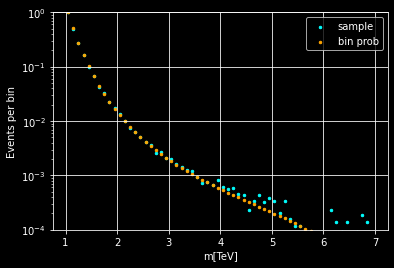

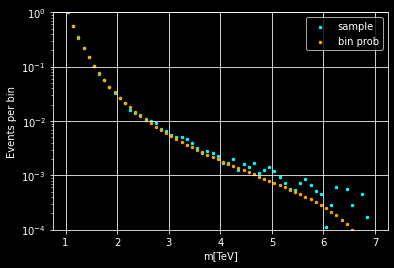

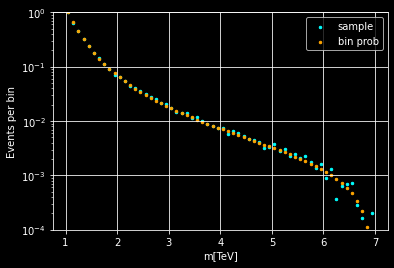

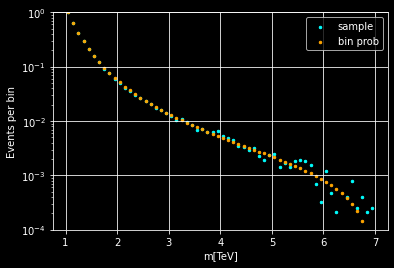

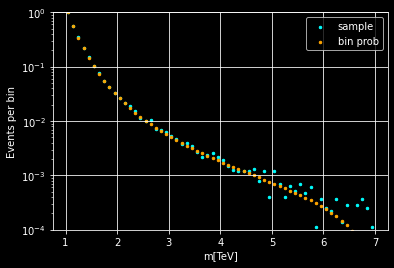

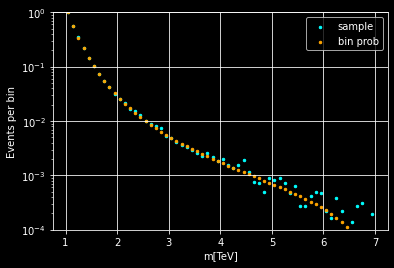

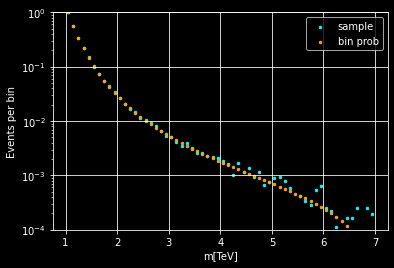

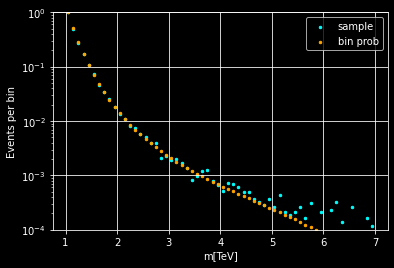

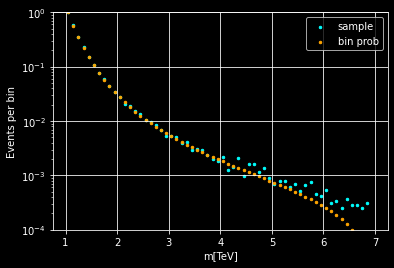

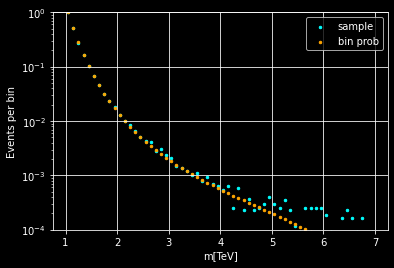

In [10]:
for i in np.random.randint(NP, size=10):
    plot1(X[i,:], Y[i,:])

In [11]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.nn import AutoRegressiveNN
pyro.enable_validation(True)

In [12]:
def build_flow(dim, visualize=True):
    if dim == 1:
        base_dist = dist.LogNormal(torch.tensor([1.2]), torch.tensor([1.2]))
        spline_transform = T.Spline(1, count_bins=12)
    elif dim == 2:
        base_dist = dist.LogNormal(torch.tensor([1.2, 1.2]), torch.tensor([1.2, 1.2]))
        spline_transform = T.spline_coupling(2, count_bins=16)
        
    if visualize:
        print("Base distribution:")
        _ = plt.hist(base_dist.sample([1000]).numpy(), bins=60)
        
    #affine_transform = T.AffineAutoregressive(AutoRegressiveNN(10, [40]))
    flow_dist = dist.TransformedDistribution(base_dist, 
                                             [spline_transform])
    return base_dist, flow_dist, spline_transform

In [61]:
def plot1p(X_test, Y_test, Y_hat, binscx, Y_base, binscb, dors):
        plt.grid()
        plt.ylim((10**-4,10**0))
        plt.xlim((1,7))
        plt.yscale("log")
        plt.scatter(binsc,X_test, s=6, label="sample",c="cyan")
        plt.scatter(binsc, prob2event(Y_test), s=6, label="true bin prob", c="orange")
        plt.scatter(prob2event(Y_hat, binscx)[1], prob2event(Y_hat, binscx)[0], s=6, label="NF flow", c="red")
        plt.scatter(prob2event(Y_base, binscb)[1], prob2event(Y_base, binscb)[0], s=6, label="NF base", c="green")
        plt.xlabel("m[TeV]")
        plt.ylabel("Events per bin")
        if dors == "d":
            plt.title("NF Test on true PDF distribution")
        if dors == "s":
            plt.title("NF Test on sample distribution")
        if dors == "u":
            plt.title("NF Test on univariate sample distribution")
        if dors == "c":
            plt.title("NF Test on conditional P(pdf|sample)")
            
        plt.legend()
        plt.show()

## Univariate

Base distribution:


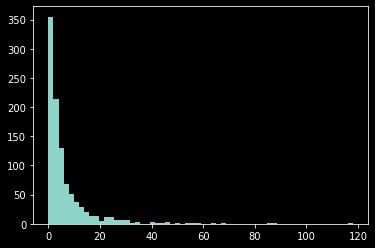

In [14]:
base_dist, flow_dist, spline_transform = build_flow(1)

In [15]:
dataset = torch.tensor(X[:20]*10000, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-5)
steps = 5001

In [16]:
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 8.497376441955566
step: 200, loss: 8.494038581848145
step: 400, loss: 8.49060344696045
step: 600, loss: 8.48693561553955
step: 800, loss: 8.483348846435547
step: 1000, loss: 8.479808807373047
step: 1200, loss: 8.475987434387207
step: 1400, loss: 8.47177791595459
step: 1600, loss: 8.466904640197754
step: 1800, loss: 8.462690353393555
step: 2000, loss: 8.461556434631348
step: 2200, loss: 8.46056842803955
step: 2400, loss: 8.459646224975586
step: 2600, loss: 8.458756446838379
step: 2800, loss: 8.457895278930664
step: 3000, loss: 8.457042694091797
step: 3200, loss: 8.456207275390625
step: 3400, loss: 8.45536994934082
step: 3600, loss: 8.454543113708496
step: 3800, loss: 8.45370864868164
step: 4000, loss: 8.452888488769531
step: 4200, loss: 8.452107429504395
step: 4400, loss: 8.451314926147461
step: 4600, loss: 8.450593948364258
step: 4800, loss: 8.449865341186523
step: 5000, loss: 8.449125289916992


In [17]:
X_flow = flow_dist.sample(torch.Size([10000,])).detach().numpy()
X_base = base_dist.sample(torch.Size([10000,])).detach().numpy()

In [18]:
print(X_flow.shape)
print(X_base.shape)

(10000, 1)
(10000, 1)


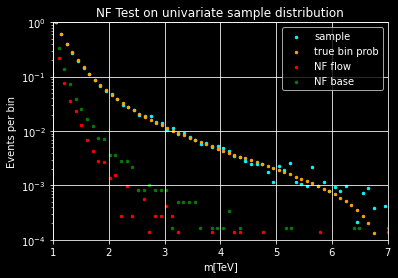

In [19]:
X_flowb, binsf = np.histogram(X_flow, bins=60) 
X_baseb, binsb = np.histogram(X_base, bins=60) 
plot1p(X[0], Y[0], X_flowb, binsf[:-1], X_baseb, binsb[:-1], "u")

## Bivariate 

Base distribution:


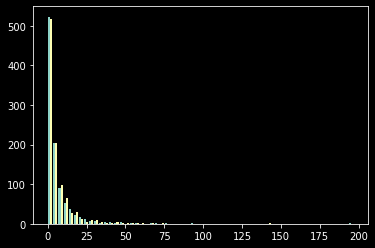

In [26]:
base_dist, flow_dist, spline_transform = build_flow(2)

In [27]:
data = np.concatenate((X, Y), axis=2)
print(data.shape)

(10000, 60, 2)


In [28]:
dataset = torch.tensor(data[:20]*1000, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-5)
steps = 5001

In [29]:
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 8.042016983032227
step: 200, loss: 7.985167503356934
step: 400, loss: 7.9299235343933105
step: 600, loss: 7.880452632904053
step: 800, loss: 7.834644317626953
step: 1000, loss: 7.788797378540039
step: 1200, loss: 7.739577770233154
step: 1400, loss: 7.694734573364258
step: 1600, loss: 7.6518635749816895
step: 1800, loss: 7.610091209411621
step: 2000, loss: 7.574003219604492
step: 2200, loss: 7.542629241943359
step: 2400, loss: 7.507918357849121
step: 2600, loss: 7.471253871917725
step: 2800, loss: 7.438479900360107
step: 3000, loss: 7.404699802398682
step: 3200, loss: 7.375205039978027
step: 3400, loss: 7.3439249992370605
step: 3600, loss: 7.315884590148926
step: 3800, loss: 7.292123794555664
step: 4000, loss: 7.269065856933594
step: 4200, loss: 7.247227191925049
step: 4400, loss: 7.225914001464844
step: 4600, loss: 7.206365585327148
step: 4800, loss: 7.188570022583008
step: 5000, loss: 7.17104959487915


In [30]:
X_flow = flow_dist.sample(torch.Size([10000,])).detach().numpy()
X_base = base_dist.sample(torch.Size([10000,])).detach().numpy()

In [31]:
print(X_flow.shape)
print(X_base.shape)

(10000, 2)
(10000, 2)


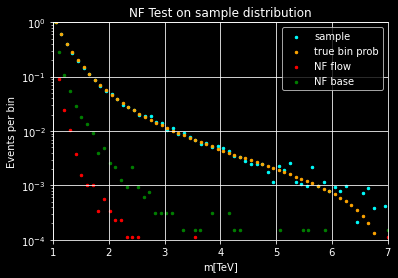

In [32]:
X_flowb, binsf = np.histogram(X_flow[:,0], bins=60) 
X_baseb, binsb = np.histogram(X_base[:,0], bins=60) 
plot1p(X[0], Y[0], X_flowb, binsf[:-1], X_baseb, binsb[:-1], "s")

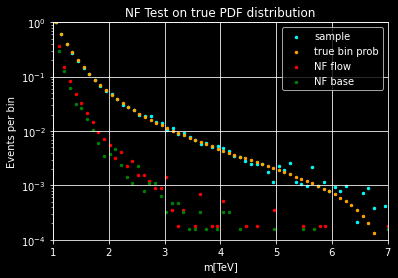

In [33]:
X_flowb, binsf = np.histogram(X_flow[:,1], bins=60) 
X_baseb, binsb = np.histogram(X_base[:,1], bins=60) 
plot1p(X[0], Y[0], X_flowb, binsf[:-1], X_baseb, binsb[:-1], "d")

## Conditional 
P(pdf|sample) = P(x2 | x1)

In [54]:
dist_base = dist.LogNormal(torch.tensor([1.2]), torch.tensor([1.2]))
sample_transform = T.Spline(1)
dist_sample = dist.TransformedDistribution(dist_base, [sample_transform])

In [55]:
pdf_transform = T.conditional_spline(1, context_dim=1)
dist_pdf_given_sample = dist.ConditionalTransformedDistribution(dist_base, [pdf_transform])

In [56]:
steps = 2001
modules = torch.nn.ModuleList([sample_transform, pdf_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=1e-6)

In [57]:
x1 = torch.tensor(X[:20]*10000, dtype=torch.float)
x2 = torch.tensor(Y[:20]*10000, dtype=torch.float)

In [58]:
for step in range(steps):
    optimizer.zero_grad()
    ln_p_x1 = dist_sample.log_prob(x1)
    ln_p_x2_given_x1 = dist_pdf_given_sample.condition(x1.detach()).log_prob(x2.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_sample.clear_cache()
    dist_pdf_given_sample.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 15.364617347717285
step: 500, loss: 15.363165855407715
step: 1000, loss: 15.361717224121094
step: 1500, loss: 15.360346794128418
step: 2000, loss: 15.358967781066895


In [59]:
X_flow_sample = dist_sample.sample(torch.Size([10000,]))
X_flow_pdf = dist_pdf_given_sample.condition(X_flow_sample).sample(torch.Size([10000,])).detach().numpy()
X_flow_sample = X_flow_sample.detach().numpy()

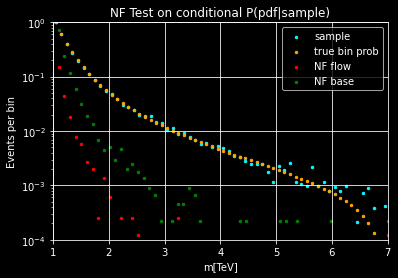

In [62]:
X_flowb, binsf = np.histogram(X_flow_sample[:,0], bins=60) 
X_baseb, binsb = np.histogram(X_flow_pdf[:,0], bins=60) 
plot1p(X[0], Y[0], X_flowb, binsf[:-1], X_baseb, binsb[:-1], "c")